In [1]:
import os
from pathlib import Path

NOTEBOOK_PATH: Path = Path(os.path.abspath(''))

DATA_PATH: Path = NOTEBOOK_PATH.parent.joinpath('data')

PATH_FOR_RESULT: Path = NOTEBOOK_PATH.joinpath('RESULT')

if not PATH_FOR_RESULT.exists():
    PATH_FOR_RESULT.mkdir()

print(f'当前运行目录：{NOTEBOOK_PATH}')
print(f'当前数据目录：{DATA_PATH}')

当前运行目录：D:\Development\Python\InvestmentWorkshop\notebook
当前数据目录：D:\Development\Python\InvestmentWorkshop\data


# 缠论 A-02

A 系列仅使用 pandas 读取数据，不用于计算。

## 准备

### 引用模块

In [2]:
from typing import List

import pandas as pd

from utility import (
    get_available_datafile_name,
    load_csv_as_dataframe,
    get_saved_filename,
    save_dataframe_to_csv
)
from InvestmentWorkshop.indicator import (
    pbx,
)
from InvestmentWorkshop.indicator.chan import (
    theory_of_chan_2,
    plot_theory_of_chan_2,
)

Load succeed.


### 设置 pandas

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 200)

### 可用数据

In [4]:
available_datafile = get_available_datafile_name(DATA_PATH, 'Minute')
for symbol, period in available_datafile:
    print(f'symbol: {symbol:>12}, period: {period}')

symbol:    DCE.c2201, period: Minute
symbol:    DCE.i2201, period: Minute
symbol:  SHFE.ag2106, period: Minute
symbol:  SHFE.al2111, period: Minute
symbol:  SHFE.al2112, period: Minute
symbol:  SHFE.hc2110, period: Minute
symbol:  SHFE.hc2201, period: Minute
symbol:  SHFE.hc2202, period: Minute
symbol:  SHFE.rb2201, period: Minute


### 声明数据

使用分钟数据

In [5]:
symbol: str = 'SHFE.al2112'
period: str = 'Minute'
dt_start: str = '2021-10-15 13:30:00'
dt_end: str = '2021-10-19 00:59:00'

### 加载数据

In [6]:
origin_data: pd.DataFrame = load_csv_as_dataframe(DATA_PATH.joinpath(f'{symbol}_{period}.csv'))
df_ohlc: pd.DataFrame = origin_data.loc[dt_start:dt_end, ['open', 'high', 'low', 'close']]

df_ohlc.info()
print('-' * 100)
df_ohlc.head(5)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 795 entries, 2021-10-15 13:30:00 to 2021-10-19 00:59:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    795 non-null    float64
 1   high    795 non-null    float64
 2   low     795 non-null    float64
 3   close   795 non-null    float64
dtypes: float64(4)
memory usage: 31.1 KB
----------------------------------------------------------------------------------------------------


,open,high,low,close
datetime,,,,
2021-10-15 13:30:00,23900.0,23900.0,23840.0,23845.0
2021-10-15 13:31:00,23845.0,23895.0,23845.0,23895.0
2021-10-15 13:32:00,23895.0,23895.0,23855.0,23875.0
2021-10-15 13:33:00,23875.0,23895.0,23840.0,23845.0
2021-10-15 13:34:00,23845.0,23855.0,23830.0,23830.0


## 结果

### 计算

In [7]:
count: int = 400
merged_candle_list, fractal_list, segment_list = theory_of_chan_2(df_ohlc, count, debug=True)


【第    0 /  399 轮】（按普通K线编号）：
    前K线（合并K线）：idx = -1, 高点 = 23900.0, 低点 = 23840.0
    本K线（普通K线）：idx = 0, 高点 = 23900.0, 低点 = 23840.0

  ● 初始化完成。

【第    1 /  399 轮】（按普通K线编号）：
    前K线（合并K线）：idx = 0, 高点 = 23900.0, 低点 = 23840.0
    本K线（普通K线）：idx = 1, 高点 = 23895.0, 低点 = 23845.0

  ○ 合并K线：
    K线关系：包含
    当前缠论K线：高点 = 23900.0，低点 = 23840.0。

  ● 处理完毕，用时 0:00:00.002994。
    合并K线数量： 1。
      前1合并K线：自 0 至 1，周期 = 2；
      前2合并K线：不存在；
      前3合并K线：不存在。

    分型数量： 0。
      分型(f-1)：不存在。
      分型(f-2)：不存在。

    线段数量： 0。
      线段(s-1)：不存在。

【第    2 /  399 轮】（按普通K线编号）：
    前K线（合并K线）：idx = 1, 高点 = 23900.0, 低点 = 23840.0
    本K线（普通K线）：idx = 2, 高点 = 23895.0, 低点 = 23855.0

  ○ 合并K线：
    K线关系：包含
    当前缠论K线：高点 = 23900.0，低点 = 23840.0。

  ● 处理完毕，用时 0:00:00.003988。
    合并K线数量： 1。
      前1合并K线：自 0 至 2，周期 = 3；
      前2合并K线：不存在；
      前3合并K线：不存在。

    分型数量： 0。
      分型(f-1)：不存在。
      分型(f-2)：不存在。

    线段数量： 0。
      线段(s-1)：不存在。

【第    3 /  399 轮】（按普通K线编号）：
    前K线（合并K线）：idx = 2, 高点 = 23900.0, 低点 = 23840.0
    本K线（普通K

### 结果

#### 合并K线

In [8]:
length: int = len(merged_candle_list)
width: int = len(str(length - 1)) + 1

for i in range(length):
    print(f'{i:>{width}}, {merged_candle_list[i]}')

   0, MergedCandle(high=23900.0, low=23840.0, idx=0, period=4, first_ordinary_idx=0)
   1, MergedCandle(high=23855.0, low=23830.0, idx=1, period=2, first_ordinary_idx=4)
   2, MergedCandle(high=23900.0, low=23875.0, idx=2, period=1, first_ordinary_idx=6)
   3, MergedCandle(high=23915.0, low=23880.0, idx=3, period=1, first_ordinary_idx=7)
   4, MergedCandle(high=23885.0, low=23845.0, idx=4, period=2, first_ordinary_idx=8)
   5, MergedCandle(high=23920.0, low=23865.0, idx=5, period=1, first_ordinary_idx=10)
   6, MergedCandle(high=23955.0, low=23910.0, idx=6, period=1, first_ordinary_idx=11)
   7, MergedCandle(high=23985.0, low=23945.0, idx=7, period=1, first_ordinary_idx=12)
   8, MergedCandle(high=23945.0, low=23915.0, idx=8, period=2, first_ordinary_idx=13)
   9, MergedCandle(high=23910.0, low=23880.0, idx=9, period=2, first_ordinary_idx=15)
  10, MergedCandle(high=23920.0, low=23895.0, idx=10, period=1, first_ordinary_idx=17)
  11, MergedCandle(high=23940.0, low=23910.0, idx=11, peri

#### 分型

In [9]:
length: int = len(fractal_list)
width: int = len(str(length - 1)) + 1

for i in range(length):
    print(f'{i:>{width}}, {fractal_list[i]}')

  0, Fractal (底分型, ordinary idx = 5, range = 23855.0 ~ 23830.0)
  1, Fractal (顶分型, ordinary idx = 12, range = 23985.0 ~ 23945.0)
  2, Fractal (顶分型, ordinary idx = 18, range = 23940.0 ~ 23910.0)
  3, Fractal (底分型, ordinary idx = 25, range = 23895.0 ~ 23870.0)
  4, Fractal (底分型, ordinary idx = 32, range = 23935.0 ~ 23915.0)
  5, Fractal (顶分型, ordinary idx = 37, range = 24015.0 ~ 23980.0)
  6, Fractal (底分型, ordinary idx = 54, range = 23930.0 ~ 23880.0)
  7, Fractal (底分型, ordinary idx = 73, range = 24075.0 ~ 24025.0)
  8, Fractal (底分型, ordinary idx = 80, range = 24290.0 ~ 24205.0)
  9, Fractal (底分型, ordinary idx = 89, range = 24430.0 ~ 24375.0)
 10, Fractal (顶分型, ordinary idx = 105, range = 24760.0 ~ 24635.0)
 11, Fractal (顶分型, ordinary idx = 112, range = 24640.0 ~ 24595.0)
 12, Fractal (底分型, ordinary idx = 132, range = 24480.0 ~ 24435.0)
 13, Fractal (顶分型, ordinary idx = 155, range = 24535.0 ~ 24480.0)
 14, Fractal (顶分型, ordinary idx = 162, range = 24450.0 ~ 24410.0)
 15, Fractal (底分型, or

#### 笔

In [10]:
# nothing to show.

#### 线段

In [11]:
length: int = len(segment_list)
width: int = len(str(length - 1)) + 1

for i in range(length):
    print(f'{i:>{width}}, {segment_list[i]}')

 0, <LinearElement (type=Segment, id=0, trend=上升, ordinary idx = 32 ~ 96)>


### 绘图

df_origin: 795
merged_candle_list: 249
fractal_list: 34
Plot done.


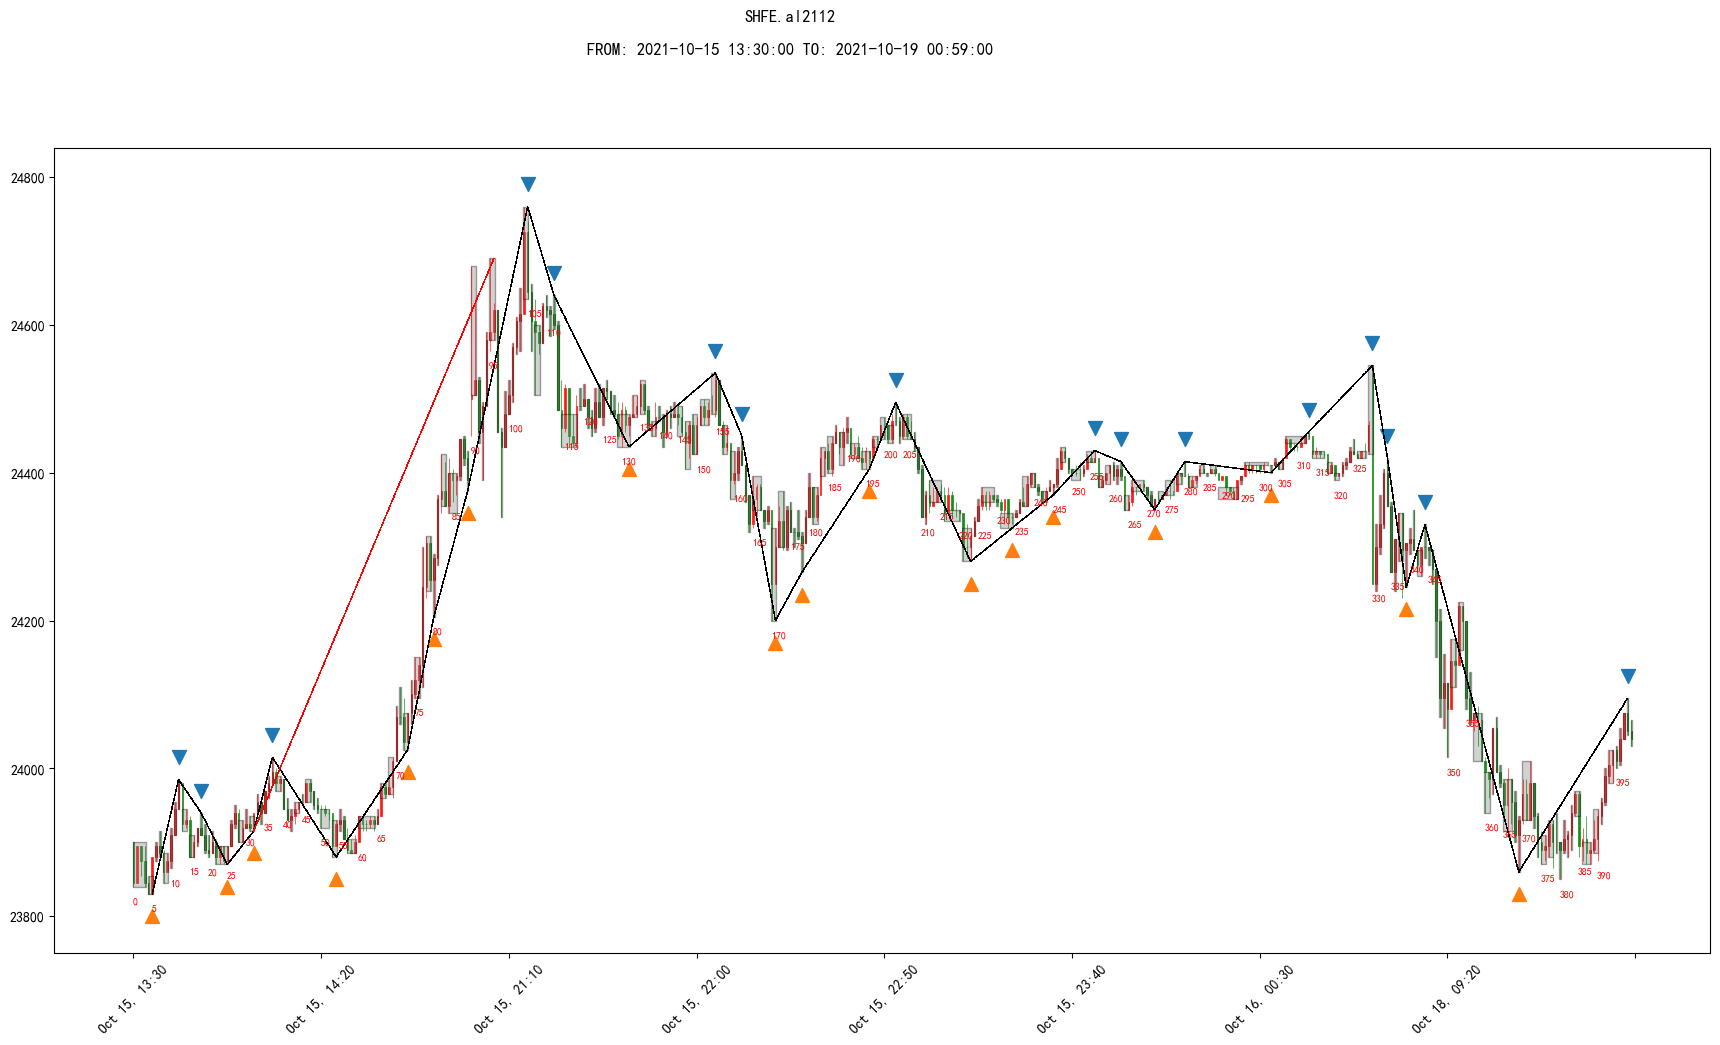

In [12]:
plot_theory_of_chan_2(
    df_ohlc,
    merged_candle_list,
    fractal_list,
    segment_list,
    count,
    title=f'{symbol}\n\nFROM: {dt_start} TO: {dt_end}',
    tight_layout=False,
    show_ordinary_idx=True,
    show_chan_idx=False,
    show_all_merged=True,
    hatch_merged=True,
    fractal_marker_size=100,
    fractal_marker_offset=30
)